In [79]:
import random
import os
import glob
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Sequential
from tensorflow.keras.utils import plot_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_recall_fscore_support
)
from scikitplot.metrics import plot_roc

In [80]:
class CFG:
    EPOCHS = 10
    BATCH_SIZE = 32
    SEED = 42
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SIZE = (224, 224, 3)

In [81]:
def seed_everything(seed=CFG.SEED):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(CFG.SEED)

Inspecting The Dataset

In [82]:
# Define paths
DATASET_PATH = "F:/Arif/Skin_ISIC_Cancer/ISIC/data"
TRAIN_PATH = 'F:/Arif/Skin_ISIC_Cancer/ISIC/data/train'
TEST_PATH = 'F:/Arif/Skin_ISIC_Cancer/ISIC/data/test'

In [83]:
# Generate a summary of the dataset
print('DATASET SUMMARY')
print('========================\n')
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
print('\n========================')

DATASET SUMMARY

There are 2 directories and 0 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data
There are 2 directories and 0 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\test
There are 0 directories and 360 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\test\benign
There are 0 directories and 300 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\test\malignant
There are 2 directories and 0 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\train
There are 0 directories and 1440 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\train\benign
There are 0 directories and 1197 images in F:/Arif/Skin_ISIC_Cancer/ISIC/data\train\malignant



Get image paths with glob

In [84]:
%%time
train_images = glob.glob(f"{TRAIN_PATH}**/*.jpg")
test_images = glob.glob(f"{TEST_PATH}**/*.jpg")

CPU times: total: 0 ns
Wall time: 999 µs


In [92]:
# Get train & test set sizes
train_size = len('F:/Arif/Skin_ISIC_Cancer/ISIC/data/train')
test_size = len('F:/Arif/Skin_ISIC_Cancer/ISIC/data/test')

# Get dataset size
total = train_size + test_size

# View samples counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		35
test samples count:		34
TOTAL:				69


In [113]:
# Define the paths to train and test directories
train_path = 'F:/Arif/Skin_ISIC_Cancer/ISIC/data/train'
test_path = 'F:/Arif/Skin_ISIC_Cancer/ISIC/data/test'

# Get the count of image files in each directory
train_size = len([file for file in os.listdir(train_path) if file.endswith('.jpg')])
test_size = len([file for file in os.listdir(test_path) if file.endswith('.jpg')])

# Calculate the total number of images
total = train_size + test_size

# Display the counts
print(f'train samples count:\t\t{train_size}')
print(f'test samples count:\t\t{test_size}')
print('=======================================')
print(f'TOTAL:\t\t\t\t{total}')

train samples count:		0
test samples count:		0
TOTAL:				0


In [93]:
def generate_labels(image_paths):
    return [_.split('/')[-2:][0] for _ in image_paths]


def build_df(image_paths, labels):
    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'label': generate_labels(labels)
    })
    
    # Generate label encodings
    df['label_encoded'] = df.apply(lambda row: 0 if row.label == 'malignant' else 1, axis=1)
    
    # Shuffle and return df
    return df.sample(frac=1, random_state=CFG.SEED).reset_index(drop=True)

In [100]:
# Build the DataFrames
train_df = build_df('F:/Skin_ISIC_Cancer/ISIC/data/train', generate_labels('F:/Skin_ISIC_Cancer/ISIC/data/train'))
test_df = build_df('F:/Skin_ISIC_Cancer/ISIC/data/test', generate_labels('F:/Skin_ISIC_Cancer/ISIC/data/test'))

In [101]:
# View first 5 samples in the training set
train_df.head(5)

,image_path,label,label_encoded
0,F:/Arif/Skin_ISIC_Cancer/ISIC/data/train,a,1
1,F:/Arif/Skin_ISIC_Cancer/ISIC/data/train,C,1
2,F:/Arif/Skin_ISIC_Cancer/ISIC/data/train,,1
3,F:/Arif/Skin_ISIC_Cancer/ISIC/data/train,S,1
4,F:/Arif/Skin_ISIC_Cancer/ISIC/data/train,n,1


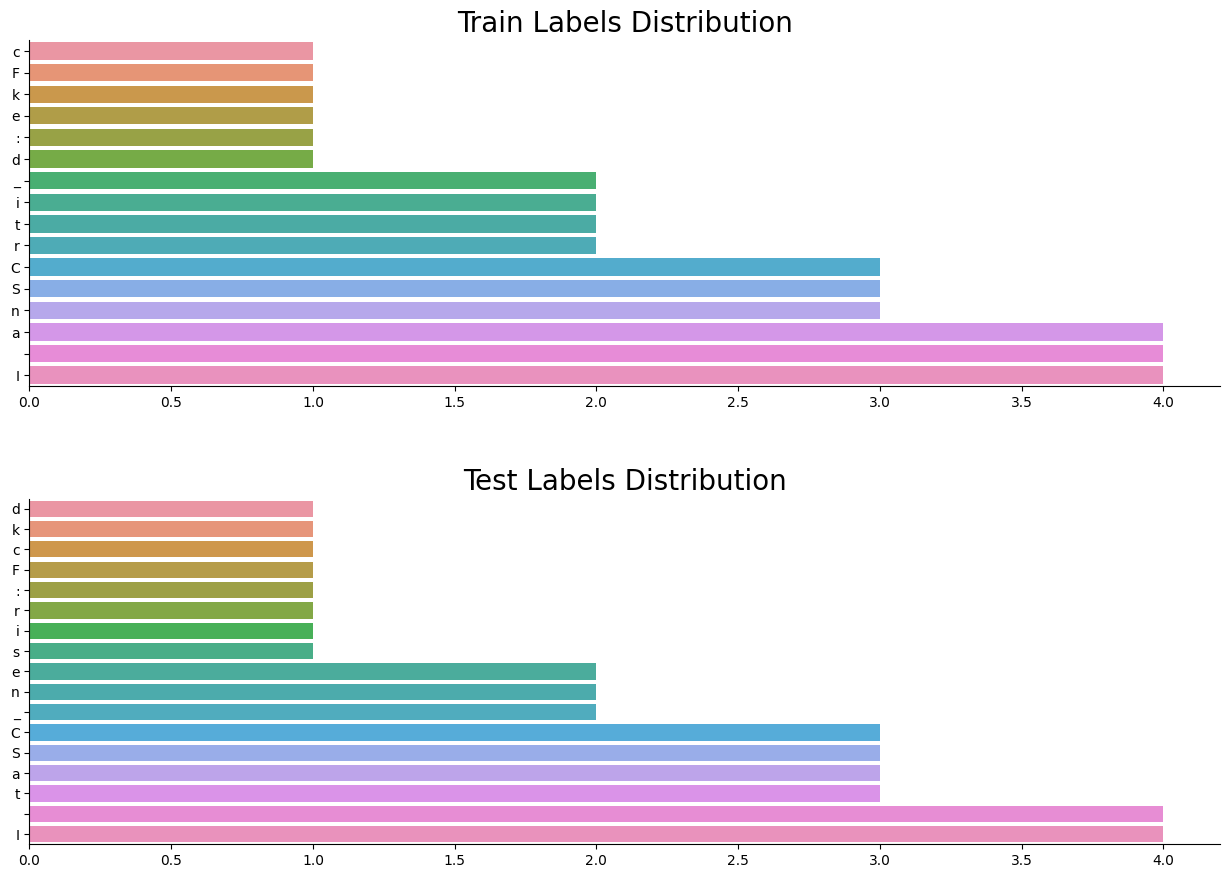

In [110]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# Plot Train Labels Distribution
ax1.set_title('Train Labels Distribution', fontsize=20)
train_distribution = train_df['label'].value_counts().sort_values()
sns.barplot(x=train_distribution.values,
            y=list(train_distribution.keys()),
            orient="h",
            ax=ax1)

# Plot Test Labels Distribution
ax2.set_title('Test Labels Distribution', fontsize=20)
test_distribution = test_df['label'].value_counts().sort_values()
sns.barplot(x=test_distribution.values,
            y=list(test_distribution.keys()),
            orient="h",
            ax=ax2);

sns.despine();

In [111]:
# Create Train/Val split with Training Set
train_split_idx, val_split_idx, _, _ = train_test_split(train_df.index, 
                                                        train_df.label_encoded, 
                                                        test_size=0.15,
                                                        stratify=train_df.label_encoded,
                                                        random_state=CFG.SEED)

In [112]:
# Get new training and validation data
train_new_df = train_df.iloc[train_split_idx].reset_index(drop=True)
val_df = train_df.iloc[val_split_idx].reset_index(drop=True)

# View shapes
train_new_df.shape, val_df.shape

((29, 3), (6, 3))

In [8]:
train_ds = 'F:/Skin_ISIC_Cancer/ISIC2018/data/train'
test_ds = 'F:/Skin_ISIC_Cancer/ISIC2018/data/test'

In [9]:
# Load image datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_ds, label_mode=None)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_ds, label_mode=None)

Found 2637 files belonging to 1 classes.
Found 660 files belonging to 1 classes.


In [10]:
# Step 1: Image Resizing and Normalization
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess a single image."""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0,1]
    return img

def prepare_dataset(image_paths, labels):
    """Prepare the entire dataset."""
    X = np.array([load_and_preprocess_image(path) for path in image_paths])
    y = np.array(labels)
    return X, y

In [11]:
# Step 2: Data Augmentation
def create_data_generators():
    """Create training and validation data generators."""
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest',
        zoom_range=0.2,
        shear_range=0.2
    )
    
    valid_datagen = ImageDataGenerator()
    
    return train_datagen, valid_datagen

In [13]:
#Step 3: Class Balancing
def compute_class_weights(y_train):
    """Compute class weights for imbalanced dataset."""
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    return dict(enumerate(class_weights))

In [14]:
# Step 4: Feature Extraction and Model Selection
def create_model(num_classes):
    """Create and compile the model."""
    # Load pre-trained EfficientNetB3
    base_model = EfficientNetB3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

In [16]:
# Freeze the base model
    base_model.trainable = False

IndentationError: unexpected indent (4207993671.py, line 2)

In [17]:
# Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

IndentationError: unexpected indent (1982184696.py, line 2)

In [18]:
# Step 5: Model Training
def train_model(model, X_train, y_train, X_val, y_val, class_weights):
    """Train the model with early stopping and learning rate reduction."""
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6
    )
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history

In [19]:
# Step 6: Model Evaluation and Validation
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print metrics."""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate metrics
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    return test_loss, test_accuracy, y_pred, y_pred_classes

In [20]:
# Step 7: Model Interpretation (Grad-CAM)
def generate_gradcam(model, img, layer_name):
    """Generate Grad-CAM visualization for a given image."""
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img]))
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

In [21]:
# Get gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

IndentationError: unexpected indent (1834119023.py, line 2)

In [22]:
# Weight and average feature maps
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    
    # Resize and overlay heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(
        cv2.cvtColor(np.uint8(img * 255), cv2.COLOR_RGB2BGR),
        0.6,
        heatmap,
        0.4,
        0
    )

IndentationError: unexpected indent (1851379998.py, line 2)